## Attention

It is widely agreed that a good starting point for a sequence-to-sequence model is a recurrent neural network and attention. In this post we'll look at applying attention to our current models.

This [Github repository](https://github.com/philipperemy/keras-attention-mechanism) by Philippe Rémy contains a great walk through for applying attention in Keras.

<img src=https://raw.githubusercontent.com/philipperemy/keras-attention-mechanism/master/assets/graph_multi_attention.png width="500">

Attention, as applied by Philippe, is fairly straightforward to implement in Keras. 

The process is as follows:

* An input is provided in with the dimensions: BS (batch_size), TS (time_steps), and I (input_dimension). I represents the length of each time step, e.g. if we had a one-hot vector with a length equal to a vocabulary size of 2500, I would be 2500. Time steps are the same as our sequence elements, e.g. if a sequence has a length of 22, time steps = 22. Batch size is the size used to group samples, e.g. for training.
* This is followed by a [Permute](https://keras.io/layers/core/#permute) operation. This swaps around the first and second dimensions (excluding the batch size I think). So you have (batch_size, input_dim, time_steps). For example, if we had (None, 22, 2500) this would be swapped to (None, 2500, 22). 
* As stated in the code the Reshape line is just for housekeeping - the array is aleady switched to being input_dim, time_steps.
* We then generate a dense layer, which is just a matrix multiplication with an output of size TS. This gives us a vector the same size as the number of our timesteps. Softmax is applied on the output to normalise as a probability (e.g. values are from 0-1 and sum to 1).
* If a single attention vector is required the mean over all dimensions is taken - a single dimension vector may be useful as a simplification when visualising.
* Some more housekeeping is then performed to again switch around the first and second dimensions (i.e. switch back to the original form).
* Finally we perform a matrix multiplication using our obtained attention vector (a_probs) on the inputs. We then output the result of the multiplication, which is the application of the attention.

Our attention weights are thus stored as parameters of the Dense layer.

In [ ]:
from keras.layers import merge, Permute, Reshape, Dense, Flatten
#from keras.layers.core import *
#from keras.layers.recurrent import LSTM
#from keras.models import *

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

The attention weights can be applied before or after our recurrent neural network (in our initial models an LSTM). When applying our weights after the LSTM we need to flatten the output to get a vector.

In [ ]:
def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

Philippe also provides a handy little utility to view the activations.

In [ ]:
import keras.backend as K
import numpy as np


def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

### Loading our Data (Again)

In [2]:
import pickle
import os

PIK = "claim_and_title.data"

if not os.path.isfile(PIK):
    # Download file
    !wget https://benhoyle.github.io/notebooks/title_generation/claim_and_title.data

with open(PIK, "rb") as f:
    print("Loading data")
    data = pickle.load(f)
    print("{0} samples loaded".format(len(data)))
    
print("\n\nAdding start and stop tokens to output")
data = [(c, "startseq {0} stopseq".format(t)) for c, t in data]
                                      
print("\n\nAn example title:", data[0][1])
print("----")
print("An example claim:", data[0][0])

Loading data
30000 samples loaded


Adding start and stop tokens to output


An example title: startseq System and method for session restoration at geo-redundant gateways stopseq
----
An example claim: 
1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reat

### Applying to Ludwig Model with Shared Embedding

Our best version of the Ludwig model is the version with shared Glove embeddings. We will apply our attention mechanism to this after the application of the LSTMs. This effectively weights the ?. We'll create a new class and overwrite the build_model method. 

We need to remember to amend the definition of the LSTM such that sequences are returned. This then enables the correct dimensionality of input for our attention layer. 

This [post](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/) explains the general functioning of the LSTM cell in Keras and the return of sequences and hidden states.

This [post](https://medium.com/datalogue/attention-in-keras-1892773a4f22) explains attention.

Some things to note:

* Some posts and text books refer to the output of an LSTM as `y`, others as `h`. The hidden state is also sometimes referred to as `h` (e.g. when used with `y`) and at other times `c` (e.g. with `h`). 

In [3]:
from ludwig_model import LudwigModel

## How this Attention Mechanism Works

Let's start by considering one sample. We can effectively ignore the first batch size (BS) dimension (0) in our code.

The attention mechanism set out above starts with an input from an encoding LSTM. As return sequences is true, the encoding LSTM outputs an array of length time steps (TS), where each time step has an associated encoding vector (I or h). In our case, we have an LSTM with a latent dimension of 128, which outputs encoding vectors of length 128 for each time step. Our Keras LSTM output for each sample is thus a matrix of size (300, 128), i.e. 300 timesteps each having a vector of length 128.

A normal Dense layer takes an input vector and maps it to an output vector, e.g. X > Y where X is length L1 and Y is length L2. If we pass a matrix to a Dense layer, e.g. 500 samples of X - of size (500, L1) we would get a matrix of (500, L2) out. This is the same if we are doing things in batches - then dense layer is still applied to the last dimension (e.g. still L1>L2 even if we had batches of 64, e.g. input - (64, 500, L1).

When we permute, we swap around our sample. So we have a sample that is the timestep data for each feature (e.g. as how each hidden dimension changes over the timesteps). E.g. `[ft1, ft2, ft3 ... fT]` where T = 22. The output of the dense layer is a (pseudo-) probability across the 22 time steps. I.e. a weighting for each time step for the feature. This is repeated for each feature so we have F_1=`[w1, w2, ... wT]`, F_2=..., F_latent_dim = `[...]` - i.e. 128 features with weights for 22 time steps (128, 22). We then swap the matrix around again, so our weights are arranged in timestep order, e.g. T_1=`[w_f1, w_f2, ..., w_f_latent_dim]` where each column / vector will sum to 1. This gives us a matrix of (22, 128).

The later Mulitply operation multiplies these weights against the original LSTM encoding.

In descriptions of attention we have a context vector that, for a output timestamp, is the weighted sum of the attention weights and the original encoding. Each encoding (h) has a weight (a).

Our issue is that the output of our Multiply operation is a matrix of (128, 22) (as we are applying weights to each individual dimension of the encoding). We need to reduce this down to a vector. The matrix has weighted terms for each latent dimension and each timestamp. We could simplify this by only having one weight term per timestamp in the earlier calculations. ***Or to sum our weights across the time dimensions.*** For this can I just use K.sum on the backend?



In [17]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, concatenate, merge, Permute, Reshape, \
Flatten, multiply, AveragePooling1D, RepeatVector, Lambda
from keras import backend as K

class LWAtt(LudwigModel):
    """ Version of our Ludwig model with attention."""
    
    def _build_model(self):
        """ Build the model. """
        print("Building model")
        self._load_shared_embedding()
        # Define inputs
        inputs_encoder = Input(shape=(self.encoder_seq_length,))
        inputs_decoder = Input(shape=(self.decoder_seq_length,))
        
        # Define Shared Embedding Layer
        Shared_Embedding = Embedding(
            output_dim=self.word_embedding_size,
            input_dim=self.num_encoder_tokens,
            weights=[self.embedding_matrix]   
        )
        # Ah our problem is that our shared embedding has encoder length but we are also using on decoder
        
        embedded_inputs_encoder = Shared_Embedding(inputs_encoder)
        embedded_inputs_decoder = Shared_Embedding(inputs_decoder)
        
        # Define LSTMs - these return output state h for each timestep (as we have r_s=True)
        encoder_LSTM = LSTM(self.latent_dim, return_sequences=True)
        decoder_LSTM = LSTM(self.latent_dim, return_sequences=True)
        
        # So output of this is, e.g. BS, 300, 128, i.e. an h vector for each TS
        encoder_context = encoder_LSTM(embedded_inputs_encoder)
        
        # Add attention to encoder encodings - here we are swapping the dims to BS, 128, 300
        a = Permute((2, 1))(encoder_context)
        #a = Reshape((self.latent_dim, self.encoder_seq_length))(a) # this line is not useful. It's just to know which dimension is what.
        # Here we apply a dense layer to each a matrix
        a = Dense(self.encoder_seq_length, activation='softmax', use_bias=False)(a)
        # Single attention vector
        # a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        # a = RepeatVector(self.latent_dim)(a)
        a_probs = Permute((2, 1), name='attention_vec_a')(a)
        att_mul_1 = multiply([encoder_context, a_probs])
        
        # Sum over time dimension
        att_mul_1 = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_1")(att_mul_1)
        # Take the average over our 300 time steps and flatten to 1D
        #flatt_mul_1 = Flatten()(AveragePooling1D(pool_size=self.encoder_seq_length, strides=None, padding='valid')(att_mul_1))
        # summary input model
        decoder_context = decoder_LSTM(embedded_inputs_decoder)
         # Add attention to answer encodings
        b = Permute((2, 1))(decoder_context)
        #b = Reshape((self.latent_dim, self.decoder_seq_length))(b) # this line is not useful. It's just to know which dimension is what.
        b = Dense(self.decoder_seq_length, activation='softmax')(b)
        # Single attention vector
        # b = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(b)
        print(b.shape) # - the above is of shape ?, 22
        #b = RepeatVector(self.latent_dim)(b) # This repeats the averaged vector across the latent dim to create a matrix of 128,22
        b_probs = Permute((2, 1), name='attention_vec_b')(b)
        att_mul_2 = multiply([decoder_context, b_probs])
        att_mul_2 = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_2")(att_mul_2)
        # Take the average over our 22 time steps and flatten to 1D
        #flatt_mul_2 = Flatten()(AveragePooling1D(pool_size=self.decoder_seq_length, strides=None, padding='valid')(att_mul_2))
        # Now flatten our attention matrices to get a vector for both sequences
        # att_mul_1 = Flatten()(att_mul_1)
        # att_mul_2 = Flatten()(att_mul_2)
        # decoder output model
        decoder1 = concatenate([att_mul_1, att_mul_2], axis=1)
        # decoder1 = concatenate([att_mul_1, att_mul_2])
        # We do need to flatten our concatenated array to a vector here
        # We can either use flatten(), which gives high dimensionality
        # Or use an average in the time dimension
        #cat_dim = self.encoder_seq_length + self.decoder_seq_length
        
        #flattened = AveragePooling1D(pool_size=cat_dim, strides=None, padding='valid')(decoder1)
        outputs = Dense(self.num_decoder_tokens, activation='softmax')(decoder1)
        # tie it together [article, summary] [word]
        self.model = Model(inputs=[inputs_encoder, inputs_decoder], outputs=outputs)
        self.infdec = self.model
        print("Compiling model")
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

In [18]:
machine = LWAtt(
    encoder_texts=[d[0] for d in data],
    decoder_texts=[d[1] for d in data],
    encoder_seq_length=300,
    decoder_seq_length=22,
    num_encoder_tokens=2500,
    num_decoder_tokens=2500,
    latent_dim=128,
    weights_file="class_LWattmodel_sin_att.hdf5",
    training_set_size=250
)

Fitting tokenizers
Our input data has shape (30000, 300) and our output data has shape (30000, 22)
Generating training and test data
Building model
Loading GloVe 100d embeddings from file
Found 400000 word vectors.
Building embedding matrix
(?, 128, 22)
Compiling model
No existing weights found


In [19]:
machine.print()

Training Model:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 300)          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         multiple             250000      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 300, 128)     117248      embedding_7[0][0]          

We have the same number of parameters. However, this time our 128 LSTM outputs have been subject to the attention weighting.

cf:
```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 100)     250000      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          117248      embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          117248      embedding_1[1][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           lstm_1[0][0]                     
                                                                 lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2500)         642500      concatenate_1[0][0]              
==================================================================================================
Total params: 1,126,996
Trainable params: 1,126,996
Non-trainable params: 0
__________________________________________________________________________________________________
None
```

In [ ]:
from keras.utils import plot_model
plot_model(machine.model)

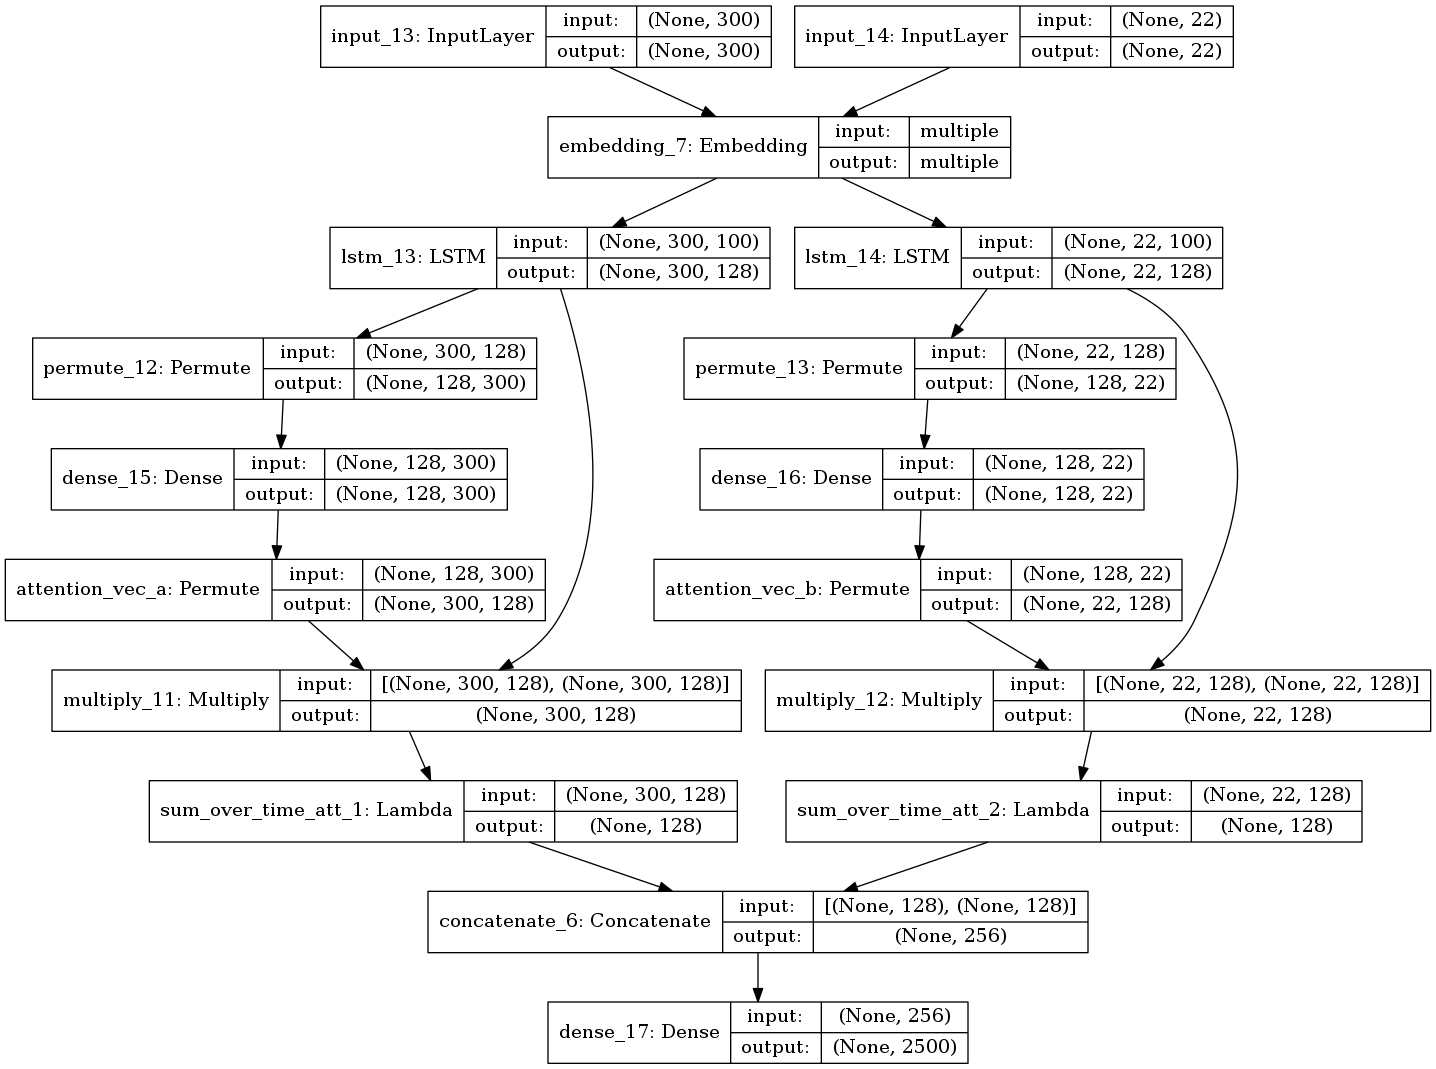

In [20]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(machine.model, show_shapes=True).create_png(prog='dot'))

Training for epoch 0
Training on batch 0 to 250 of 24000
Train on 2639 samples, validate on 655 samples
Epoch 1/1
2639/2639 [==============================] - 38s 14ms/step - loss: 3.7534 - val_loss: 3.4038
Training on batch 250 to 500 of 24000
Train on 2484 samples, validate on 658 samples
Epoch 1/1
2484/2484 [==============================] - 36s 14ms/step - loss: 3.3330 - val_loss: 3.2739
Training on batch 500 to 750 of 24000
Train on 2586 samples, validate on 583 samples
Epoch 1/1
2586/2586 [==============================] - 39s 15ms/step - loss: 3.3971 - val_loss: 3.3970
Training on batch 750 to 1000 of 24000
Train on 2613 samples, validate on 667 samples
Epoch 1/1
2613/2613 [==============================] - 39s 15ms/step - loss: 3.3393 - val_loss: 3.1085
Training on batch 1000 to 1250 of 24000
Train on 2532 samples, validate on 687 samples
Epoch 1/1
2532/2532 [==============================] - 39s 16ms/step - loss: 3.2977 - val_loss: 3.5505
Training on batch 1250 to 1500 of 2400

2465/2465 [==============================] - 38s 15ms/step - loss: 2.7356 - val_loss: 2.8176
Training on batch 11000 to 11250 of 24000
Train on 2399 samples, validate on 669 samples
Epoch 1/1
2399/2399 [==============================] - 36s 15ms/step - loss: 2.6346 - val_loss: 2.8013
Training on batch 11250 to 11500 of 24000
Train on 2476 samples, validate on 669 samples
Epoch 1/1
2476/2476 [==============================] - 38s 15ms/step - loss: 2.7271 - val_loss: 2.6684
Training on batch 11500 to 11750 of 24000
Train on 2450 samples, validate on 648 samples
Epoch 1/1
2450/2450 [==============================] - 37s 15ms/step - loss: 2.5915 - val_loss: 2.7757
Training on batch 11750 to 12000 of 24000
Train on 2553 samples, validate on 646 samples
Epoch 1/1
2553/2553 [==============================] - 39s 15ms/step - loss: 2.6833 - val_loss: 2.5717
Training on batch 12000 to 12250 of 24000
Train on 2395 samples, validate on 595 samples
Epoch 1/1
2395/2395 [=============================

2534/2534 [==============================] - 38s 15ms/step - loss: 2.4993 - val_loss: 2.4743
Training on batch 21750 to 22000 of 24000
Train on 2515 samples, validate on 693 samples
Epoch 1/1
2515/2515 [==============================] - 38s 15ms/step - loss: 2.6064 - val_loss: 2.7787
Training on batch 22000 to 22250 of 24000
Train on 2586 samples, validate on 627 samples
Epoch 1/1
2586/2586 [==============================] - 39s 15ms/step - loss: 2.3296 - val_loss: 2.4972
Training on batch 22250 to 22500 of 24000
Train on 2543 samples, validate on 676 samples
Epoch 1/1
2543/2543 [==============================] - 37s 15ms/step - loss: 2.4877 - val_loss: 2.6850
Training on batch 22500 to 22750 of 24000
Train on 2487 samples, validate on 582 samples
Epoch 1/1
2487/2487 [==============================] - 38s 15ms/step - loss: 2.5702 - val_loss: 2.3874
Training on batch 22750 to 23000 of 24000
Train on 2557 samples, validate on 610 samples
Epoch 1/1
2557/2557 [=============================

Training on batch 5750 to 6000 of 24000
Train on 2476 samples, validate on 606 samples
Epoch 1/1
2476/2476 [==============================] - 37s 15ms/step - loss: 2.3335 - val_loss: 2.7420
Training on batch 6000 to 6250 of 24000
Train on 2531 samples, validate on 637 samples
Epoch 1/1
2531/2531 [==============================] - 37s 15ms/step - loss: 2.3364 - val_loss: 2.3899
Training on batch 6250 to 6500 of 24000
Train on 2574 samples, validate on 602 samples
Epoch 1/1
2574/2574 [==============================] - 38s 15ms/step - loss: 2.5500 - val_loss: 2.3414
Training on batch 6500 to 6750 of 24000
Train on 2479 samples, validate on 602 samples
Epoch 1/1
2479/2479 [==============================] - 37s 15ms/step - loss: 2.5098 - val_loss: 2.6371
Training on batch 6750 to 7000 of 24000
Train on 2548 samples, validate on 625 samples
Epoch 1/1
2548/2548 [==============================] - 39s 15ms/step - loss: 2.4664 - val_loss: 2.5697
Training on batch 7000 to 7250 of 24000
Train on 2

2471/2471 [==============================] - 36s 15ms/step - loss: 2.2770 - val_loss: 2.3475
Training on batch 16500 to 16750 of 24000
Train on 2562 samples, validate on 637 samples
Epoch 1/1
2562/2562 [==============================] - 38s 15ms/step - loss: 2.2670 - val_loss: 2.4601
Training on batch 16750 to 17000 of 24000
Train on 2482 samples, validate on 651 samples
Epoch 1/1
2482/2482 [==============================] - 37s 15ms/step - loss: 2.2533 - val_loss: 2.3826
Training on batch 17000 to 17250 of 24000
Train on 2656 samples, validate on 616 samples
Epoch 1/1
2656/2656 [==============================] - 39s 15ms/step - loss: 2.4341 - val_loss: 2.4093
Training on batch 17250 to 17500 of 24000
Train on 2466 samples, validate on 654 samples
Epoch 1/1
2466/2466 [==============================] - 38s 15ms/step - loss: 2.2674 - val_loss: 2.4955
Training on batch 17500 to 17750 of 24000
Train on 2575 samples, validate on 645 samples
Epoch 1/1
2575/2575 [=============================

2586/2586 [==============================] - 38s 15ms/step - loss: 2.2952 - val_loss: 2.7047
Training on batch 750 to 1000 of 24000
Train on 2613 samples, validate on 667 samples
Epoch 1/1
2613/2613 [==============================] - 40s 15ms/step - loss: 2.2876 - val_loss: 2.3689
Training on batch 1000 to 1250 of 24000
Train on 2532 samples, validate on 687 samples
Epoch 1/1
2532/2532 [==============================] - 38s 15ms/step - loss: 2.1495 - val_loss: 2.6779
Training on batch 1250 to 1500 of 24000
Train on 2481 samples, validate on 699 samples
Epoch 1/1
2481/2481 [==============================] - 38s 15ms/step - loss: 2.2951 - val_loss: 2.3304
Training on batch 1500 to 1750 of 24000
Train on 2425 samples, validate on 625 samples
Epoch 1/1
2425/2425 [==============================] - 36s 15ms/step - loss: 2.2643 - val_loss: 2.3082
Training on batch 1750 to 2000 of 24000
Train on 2575 samples, validate on 625 samples
Epoch 1/1
2575/2575 [==============================] - 38s 15

2476/2476 [==============================] - 37s 15ms/step - loss: 2.1684 - val_loss: 2.3204
Training on batch 11500 to 11750 of 24000
Train on 2450 samples, validate on 648 samples
Epoch 1/1
2450/2450 [==============================] - 37s 15ms/step - loss: 2.1230 - val_loss: 2.3439
Training on batch 11750 to 12000 of 24000
Train on 2553 samples, validate on 646 samples
Epoch 1/1
2553/2553 [==============================] - 39s 15ms/step - loss: 2.1668 - val_loss: 2.2115
Training on batch 12000 to 12250 of 24000
Train on 2395 samples, validate on 595 samples
Epoch 1/1
2395/2395 [==============================] - 36s 15ms/step - loss: 2.1125 - val_loss: 2.4422
Training on batch 12250 to 12500 of 24000
Train on 2497 samples, validate on 617 samples
Epoch 1/1
2497/2497 [==============================] - 37s 15ms/step - loss: 2.1455 - val_loss: 2.3798
Training on batch 12500 to 12750 of 24000
Train on 2535 samples, validate on 641 samples
Epoch 1/1
2535/2535 [=============================

2586/2586 [==============================] - 39s 15ms/step - loss: 2.0001 - val_loss: 2.5303
Training on batch 22250 to 22500 of 24000
Train on 2543 samples, validate on 676 samples
Epoch 1/1
2543/2543 [==============================] - 38s 15ms/step - loss: 2.1153 - val_loss: 2.3722
Training on batch 22500 to 22750 of 24000
Train on 2487 samples, validate on 582 samples
Epoch 1/1
2487/2487 [==============================] - 37s 15ms/step - loss: 2.1752 - val_loss: 2.1959
Training on batch 22750 to 23000 of 24000
Train on 2557 samples, validate on 610 samples
Epoch 1/1
2557/2557 [==============================] - 39s 15ms/step - loss: 2.0757 - val_loss: 2.0612
Training on batch 23000 to 23250 of 24000
Train on 2364 samples, validate on 661 samples
Epoch 1/1
2364/2364 [==============================] - 36s 15ms/step - loss: 2.0869 - val_loss: 2.3929
Training on batch 23250 to 23500 of 24000
Train on 2538 samples, validate on 637 samples
Epoch 1/1
2538/2538 [=============================

2574/2574 [==============================] - 38s 15ms/step - loss: 2.1539 - val_loss: 2.0839
Training on batch 6500 to 6750 of 24000
Train on 2479 samples, validate on 602 samples
Epoch 1/1
2479/2479 [==============================] - 37s 15ms/step - loss: 2.0141 - val_loss: 2.4947
Training on batch 6750 to 7000 of 24000
Train on 2548 samples, validate on 625 samples
Epoch 1/1
2548/2548 [==============================] - 38s 15ms/step - loss: 2.0927 - val_loss: 2.4430
Training on batch 7000 to 7250 of 24000
Train on 2603 samples, validate on 671 samples
Epoch 1/1
2603/2603 [==============================] - 40s 15ms/step - loss: 2.1461 - val_loss: 2.2826
Training on batch 7250 to 7500 of 24000
Train on 2541 samples, validate on 616 samples
Epoch 1/1
2541/2541 [==============================] - 38s 15ms/step - loss: 2.0771 - val_loss: 2.2364
Training on batch 7500 to 7750 of 24000
Train on 2537 samples, validate on 672 samples
Epoch 1/1
2537/2537 [==============================] - 38s 1

2656/2656 [==============================] - 40s 15ms/step - loss: 2.1706 - val_loss: 2.2973
Training on batch 17250 to 17500 of 24000
Train on 2466 samples, validate on 654 samples
Epoch 1/1
2466/2466 [==============================] - 37s 15ms/step - loss: 2.0034 - val_loss: 2.3894
Training on batch 17500 to 17750 of 24000
Train on 2575 samples, validate on 645 samples
Epoch 1/1
2575/2575 [==============================] - 38s 15ms/step - loss: 2.0412 - val_loss: 2.2152
Training on batch 17750 to 18000 of 24000
Train on 2452 samples, validate on 706 samples
Epoch 1/1
2452/2452 [==============================] - 38s 15ms/step - loss: 2.0022 - val_loss: 2.3838
Training on batch 18000 to 18250 of 24000
Train on 2575 samples, validate on 568 samples
Epoch 1/1
2575/2575 [==============================] - 39s 15ms/step - loss: 1.9503 - val_loss: 2.4582
Training on batch 18250 to 18500 of 24000
Train on 2592 samples, validate on 641 samples
Epoch 1/1
2592/2592 [=============================

2481/2481 [==============================] - 38s 15ms/step - loss: 2.0390 - val_loss: 2.3195
Training on batch 1500 to 1750 of 24000
Train on 2425 samples, validate on 625 samples
Epoch 1/1
2425/2425 [==============================] - 37s 15ms/step - loss: 1.9995 - val_loss: 2.2595
Training on batch 1750 to 2000 of 24000
Train on 2575 samples, validate on 625 samples
Epoch 1/1
2575/2575 [==============================] - 38s 15ms/step - loss: 2.0446 - val_loss: 2.2788
Training on batch 2000 to 2250 of 24000
Train on 2449 samples, validate on 622 samples
Epoch 1/1
2449/2449 [==============================] - 37s 15ms/step - loss: 1.9518 - val_loss: 2.3616
Training on batch 2250 to 2500 of 24000
Train on 2568 samples, validate on 661 samples
Epoch 1/1
2568/2568 [==============================] - 39s 15ms/step - loss: 2.0656 - val_loss: 2.3839
Training on batch 2500 to 2750 of 24000
Train on 2459 samples, validate on 607 samples
Epoch 1/1
2459/2459 [==============================] - 37s 1

2395/2395 [==============================] - 36s 15ms/step - loss: 1.9589 - val_loss: 2.2240
Training on batch 12250 to 12500 of 24000
Train on 2497 samples, validate on 617 samples
Epoch 1/1
2497/2497 [==============================] - 38s 15ms/step - loss: 1.8790 - val_loss: 2.4197
Training on batch 12500 to 12750 of 24000
Train on 2535 samples, validate on 641 samples
Epoch 1/1
2535/2535 [==============================] - 38s 15ms/step - loss: 1.8884 - val_loss: 2.3789
Training on batch 12750 to 13000 of 24000
Train on 2426 samples, validate on 604 samples
Epoch 1/1
2426/2426 [==============================] - 37s 15ms/step - loss: 1.9196 - val_loss: 2.1776
Training on batch 13000 to 13250 of 24000
Train on 2445 samples, validate on 605 samples
Epoch 1/1
2445/2445 [==============================] - 37s 15ms/step - loss: 1.8642 - val_loss: 2.3242
Training on batch 13250 to 13500 of 24000
Train on 2408 samples, validate on 672 samples
Epoch 1/1
2408/2408 [=============================

2557/2557 [==============================] - 39s 15ms/step - loss: 1.8234 - val_loss: 2.1103
Training on batch 23000 to 23250 of 24000
Train on 2364 samples, validate on 661 samples
Epoch 1/1
2364/2364 [==============================] - 35s 15ms/step - loss: 1.8862 - val_loss: 2.2971
Training on batch 23250 to 23500 of 24000
Train on 2538 samples, validate on 637 samples
Epoch 1/1
2538/2538 [==============================] - 38s 15ms/step - loss: 1.9173 - val_loss: 2.3723
Training on batch 23500 to 23750 of 24000
Train on 2373 samples, validate on 637 samples
Epoch 1/1
2373/2373 [==============================] - 36s 15ms/step - loss: 1.8432 - val_loss: 2.2497
Training on batch 23750 to 24000 of 24000
Train on 2593 samples, validate on 590 samples
Epoch 1/1
2593/2593 [==============================] - 38s 15ms/step - loss: 1.8190 - val_loss: 2.3745
------------------------------------------
Sample of claim text: 1 a method for search phrases comprising obtaining one or more subject ter

2603/2603 [==============================] - 39s 15ms/step - loss: 1.9637 - val_loss: 2.3198
Training on batch 7250 to 7500 of 24000
Train on 2541 samples, validate on 616 samples
Epoch 1/1
2541/2541 [==============================] - 39s 15ms/step - loss: 1.8730 - val_loss: 2.1403
Training on batch 7500 to 7750 of 24000
Train on 2537 samples, validate on 672 samples
Epoch 1/1
2537/2537 [==============================] - 38s 15ms/step - loss: 1.8717 - val_loss: 2.4447
Training on batch 7750 to 8000 of 24000
Train on 2616 samples, validate on 641 samples
Epoch 1/1
2616/2616 [==============================] - 39s 15ms/step - loss: 1.8586 - val_loss: 2.3745
Training on batch 8000 to 8250 of 24000
Train on 2567 samples, validate on 638 samples
Epoch 1/1
2567/2567 [==============================] - 39s 15ms/step - loss: 1.8834 - val_loss: 2.4168
Training on batch 8250 to 8500 of 24000
Train on 2631 samples, validate on 619 samples
Epoch 1/1
2631/2631 [==============================] - 39s 1

2452/2452 [==============================] - 37s 15ms/step - loss: 1.8360 - val_loss: 2.4494
Training on batch 18000 to 18250 of 24000
Train on 2575 samples, validate on 568 samples
Epoch 1/1
2575/2575 [==============================] - 39s 15ms/step - loss: 1.8007 - val_loss: 2.4485
Training on batch 18250 to 18500 of 24000
Train on 2592 samples, validate on 641 samples
Epoch 1/1
2592/2592 [==============================] - 38s 15ms/step - loss: 1.7686 - val_loss: 2.2811
Training on batch 18500 to 18750 of 24000
Train on 2527 samples, validate on 634 samples
Epoch 1/1
2527/2527 [==============================] - 38s 15ms/step - loss: 1.7539 - val_loss: 2.4462
Training on batch 18750 to 19000 of 24000
Train on 2495 samples, validate on 652 samples
Epoch 1/1
2495/2495 [==============================] - 38s 15ms/step - loss: 1.7884 - val_loss: 2.5240
Training on batch 19000 to 19250 of 24000
Train on 2460 samples, validate on 638 samples
Epoch 1/1
2460/2460 [=============================

Training on batch 2000 to 2250 of 24000
Train on 2449 samples, validate on 622 samples
Epoch 1/1
2449/2449 [==============================] - 37s 15ms/step - loss: 1.7645 - val_loss: 2.4645
Training on batch 2250 to 2500 of 24000
Train on 2568 samples, validate on 661 samples
Epoch 1/1
2568/2568 [==============================] - 39s 15ms/step - loss: 1.8502 - val_loss: 2.5789
Training on batch 2500 to 2750 of 24000
Train on 2459 samples, validate on 607 samples
Epoch 1/1
2459/2459 [==============================] - 37s 15ms/step - loss: 1.7554 - val_loss: 2.3899
Training on batch 2750 to 3000 of 24000
Train on 2530 samples, validate on 603 samples
Epoch 1/1
2530/2530 [==============================] - 38s 15ms/step - loss: 1.7861 - val_loss: 2.2814
Training on batch 3000 to 3250 of 24000
Train on 2466 samples, validate on 721 samples
Epoch 1/1
2466/2466 [==============================] - 37s 15ms/step - loss: 1.6978 - val_loss: 2.3737
Training on batch 3250 to 3500 of 24000
Train on 2

Training on batch 12750 to 13000 of 24000
Train on 2426 samples, validate on 604 samples
Epoch 1/1
2426/2426 [==============================] - 36s 15ms/step - loss: 1.7128 - val_loss: 2.0988
Training on batch 13000 to 13250 of 24000
Train on 2445 samples, validate on 605 samples
Epoch 1/1
2445/2445 [==============================] - 37s 15ms/step - loss: 1.6980 - val_loss: 2.3369
Training on batch 13250 to 13500 of 24000
Train on 2408 samples, validate on 672 samples
Epoch 1/1
2408/2408 [==============================] - 37s 15ms/step - loss: 1.6912 - val_loss: 2.4283
Training on batch 13500 to 13750 of 24000
Train on 2426 samples, validate on 646 samples
Epoch 1/1
2426/2426 [==============================] - 36s 15ms/step - loss: 1.7422 - val_loss: 2.1557
Training on batch 13750 to 14000 of 24000
Train on 2573 samples, validate on 626 samples
Epoch 1/1
2573/2573 [==============================] - 39s 15ms/step - loss: 1.6861 - val_loss: 2.4559
Training on batch 14000 to 14250 of 2400

2538/2538 [==============================] - 38s 15ms/step - loss: 1.7100 - val_loss: 2.3093
Training on batch 23500 to 23750 of 24000
Train on 2373 samples, validate on 637 samples
Epoch 1/1
2373/2373 [==============================] - 36s 15ms/step - loss: 1.6939 - val_loss: 2.3479
Training on batch 23750 to 24000 of 24000
Train on 2593 samples, validate on 590 samples
Epoch 1/1
2593/2593 [==============================] - 39s 15ms/step - loss: 1.6179 - val_loss: 2.3963
------------------------------------------
Sample of claim text: 1 a method for operating a working machine provided with a hydraulic system for moving an implement on the working machine and or for steering the working machine and an operator control means which i

Predicted title is: method and system for controlling a machine machine  
Actual title is: method and a system for operating a working machine  
---
Sample of claim text: 1 a method for training a learning based classifier comprising generating a plurality

2537/2537 [==============================] - 37s 15ms/step - loss: 1.7243 - val_loss: 2.4982
Training on batch 7750 to 8000 of 24000
Train on 2616 samples, validate on 641 samples
Epoch 1/1
2616/2616 [==============================] - 40s 15ms/step - loss: 1.6771 - val_loss: 2.3241
Training on batch 8000 to 8250 of 24000
Train on 2567 samples, validate on 638 samples
Epoch 1/1
2567/2567 [==============================] - 38s 15ms/step - loss: 1.7520 - val_loss: 2.5261
Training on batch 8250 to 8500 of 24000
Train on 2631 samples, validate on 619 samples
Epoch 1/1
2631/2631 [==============================] - 40s 15ms/step - loss: 1.7072 - val_loss: 2.3001
Training on batch 8500 to 8750 of 24000
Train on 2427 samples, validate on 618 samples
Epoch 1/1
2427/2427 [==============================] - 36s 15ms/step - loss: 1.7177 - val_loss: 2.6276
Training on batch 8750 to 9000 of 24000
Train on 2627 samples, validate on 655 samples
Epoch 1/1
2627/2627 [==============================] - 40s 1

2592/2592 [==============================] - 39s 15ms/step - loss: 1.6292 - val_loss: 2.4093
Training on batch 18500 to 18750 of 24000
Train on 2527 samples, validate on 634 samples
Epoch 1/1
2527/2527 [==============================] - 38s 15ms/step - loss: 1.6186 - val_loss: 2.3403
Training on batch 18750 to 19000 of 24000
Train on 2495 samples, validate on 652 samples
Epoch 1/1
2495/2495 [==============================] - 36s 15ms/step - loss: 1.6435 - val_loss: 2.6449
Training on batch 19000 to 19250 of 24000
Train on 2460 samples, validate on 638 samples
Epoch 1/1
2460/2460 [==============================] - 36s 15ms/step - loss: 1.6946 - val_loss: 2.3160
Training on batch 19250 to 19500 of 24000
Train on 2573 samples, validate on 652 samples
Epoch 1/1
2573/2573 [==============================] - 39s 15ms/step - loss: 1.5668 - val_loss: 2.4831
Training on batch 19500 to 19750 of 24000
Train on 2643 samples, validate on 668 samples
Epoch 1/1
2643/2643 [=============================

2568/2568 [==============================] - 38s 15ms/step - loss: 1.6804 - val_loss: 2.5025
Training on batch 2500 to 2750 of 24000
Train on 2459 samples, validate on 607 samples
Epoch 1/1
2459/2459 [==============================] - 37s 15ms/step - loss: 1.5742 - val_loss: 2.3063
Training on batch 2750 to 3000 of 24000
Train on 2530 samples, validate on 603 samples
Epoch 1/1
2530/2530 [==============================] - 38s 15ms/step - loss: 1.6900 - val_loss: 2.3100
Training on batch 3000 to 3250 of 24000
Train on 2466 samples, validate on 721 samples
Epoch 1/1
2466/2466 [==============================] - 37s 15ms/step - loss: 1.5628 - val_loss: 2.1538
Training on batch 3250 to 3500 of 24000
Train on 2491 samples, validate on 643 samples
Epoch 1/1
2491/2491 [==============================] - 37s 15ms/step - loss: 1.6507 - val_loss: 2.1759
Training on batch 3500 to 3750 of 24000
Train on 2568 samples, validate on 595 samples
Epoch 1/1
2568/2568 [==============================] - 39s 1

2445/2445 [==============================] - 36s 15ms/step - loss: 1.6197 - val_loss: 2.3233
Training on batch 13250 to 13500 of 24000
Train on 2408 samples, validate on 672 samples
Epoch 1/1
2408/2408 [==============================] - 36s 15ms/step - loss: 1.5903 - val_loss: 2.3548
Training on batch 13500 to 13750 of 24000
Train on 2426 samples, validate on 646 samples
Epoch 1/1
2426/2426 [==============================] - 37s 15ms/step - loss: 1.5610 - val_loss: 2.3323
Training on batch 13750 to 14000 of 24000
Train on 2573 samples, validate on 626 samples
Epoch 1/1
2573/2573 [==============================] - 38s 15ms/step - loss: 1.5515 - val_loss: 2.5894
Training on batch 14000 to 14250 of 24000
Train on 2571 samples, validate on 619 samples
Epoch 1/1
2571/2571 [==============================] - 39s 15ms/step - loss: 1.6150 - val_loss: 2.6002
Training on batch 14250 to 14500 of 24000
Train on 2559 samples, validate on 620 samples
Epoch 1/1
2559/2559 [=============================

2593/2593 [==============================] - 39s 15ms/step - loss: 1.6046 - val_loss: 2.4217
------------------------------------------
Sample of claim text: 1 a method comprising obtaining one or more historical contextual values from one or more the one or more historical contextual values corresponding to historical instances where a device action was p

Predicted title is: system and method for providing an integrated user to an integrated development environment  
Actual title is: context based device action prediction  
---
Sample of claim text: 1 a method of operating a touch screen device having a touch screen having a first area and a second area the method comprising displaying a plurality of menu images corresponding to a plurality of in

Predicted title is: method and system for displaying a screen screen  
Actual title is: touch screen device and operating method thereof  
---
Sample of claim text: loaded at the first web browser to the second web browser at the second via

2567/2567 [==============================] - 39s 15ms/step - loss: 1.6167 - val_loss: 2.5450
Training on batch 8250 to 8500 of 24000
Train on 2631 samples, validate on 619 samples
Epoch 1/1
2631/2631 [==============================] - 40s 15ms/step - loss: 1.6069 - val_loss: 2.3126
Training on batch 8500 to 8750 of 24000
Train on 2427 samples, validate on 618 samples
Epoch 1/1
2427/2427 [==============================] - 35s 15ms/step - loss: 1.6490 - val_loss: 2.5232
Training on batch 8750 to 9000 of 24000
Train on 2627 samples, validate on 655 samples
Epoch 1/1
2627/2627 [==============================] - 39s 15ms/step - loss: 1.5631 - val_loss: 2.1616
Training on batch 9000 to 9250 of 24000
Train on 2536 samples, validate on 629 samples
Epoch 1/1
2536/2536 [==============================] - 38s 15ms/step - loss: 1.5223 - val_loss: 2.4680
Training on batch 9250 to 9500 of 24000
Train on 2473 samples, validate on 646 samples
Epoch 1/1
2473/2473 [==============================] - 36s 1

2495/2495 [==============================] - 38s 15ms/step - loss: 1.5206 - val_loss: 2.6160
Training on batch 19000 to 19250 of 24000
Train on 2460 samples, validate on 638 samples
Epoch 1/1
2460/2460 [==============================] - 38s 15ms/step - loss: 1.5692 - val_loss: 2.3697
Training on batch 19250 to 19500 of 24000
Train on 2573 samples, validate on 652 samples
Epoch 1/1
2573/2573 [==============================] - 39s 15ms/step - loss: 1.4512 - val_loss: 2.6953
Training on batch 19500 to 19750 of 24000
Train on 2643 samples, validate on 668 samples
Epoch 1/1
2643/2643 [==============================] - 39s 15ms/step - loss: 1.6049 - val_loss: 2.4932
Training on batch 19750 to 20000 of 24000
Train on 2531 samples, validate on 623 samples
Epoch 1/1
2531/2531 [==============================] - 37s 15ms/step - loss: 1.5835 - val_loss: 2.4037
Training on batch 20000 to 20250 of 24000
Train on 2530 samples, validate on 642 samples
Epoch 1/1
2530/2530 [=============================

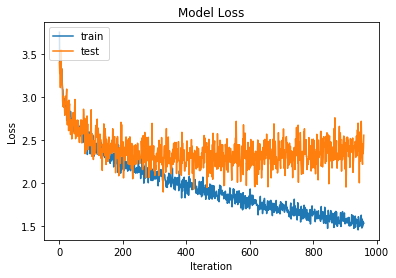

In [21]:
machine.train(epochs=10)

### Comments on Training

The training and test loss start to diverge around 250 iterations. Then the model starts overfitting on the training data. We could probably do with some regularisation to prevent overfitting and keep the test loss in sync with the training loss.

We also need to set up the save weights so it only saves in the test loss has not increased by a margin.

Let's try with some regularisation using Dropout and L2 regularizer.

In [22]:
from keras.regularizers import l2 # L2-regularisation
l2_lambda = 0.01

class LWAtt_reg(LudwigModel):
    """ Version of our Ludwig model with attention."""
    
    def _build_model(self):
        """ Build the model. """
        print("Building model")
        self._load_shared_embedding()
        # Define inputs
        inputs_encoder = Input(shape=(self.encoder_seq_length,))
        inputs_decoder = Input(shape=(self.decoder_seq_length,))
        
        # Define Shared Embedding Layer
        Shared_Embedding = Embedding(
            output_dim=self.word_embedding_size,
            input_dim=self.num_encoder_tokens,
            weights=[self.embedding_matrix]   
        )
        # Ah our problem is that our shared embedding has encoder length but we are also using on decoder
        
        embedded_inputs_encoder = Shared_Embedding(inputs_encoder)
        embedded_inputs_decoder = Shared_Embedding(inputs_decoder)
        
        # Define LSTMs - these return output state h for each timestep (as we have r_s=True)
        encoder_LSTM = LSTM(self.latent_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
        decoder_LSTM = LSTM(self.latent_dim, return_sequences=True,  dropout=0.2, recurrent_dropout=0.2)
        
        # So output of this is, e.g. BS, 300, 128, i.e. an h vector for each TS
        encoder_context = encoder_LSTM(embedded_inputs_encoder)
        
        # Add attention to encoder encodings - here we are swapping the dims to BS, 128, 300
        a = Permute((2, 1))(encoder_context)

        a = Dense(self.encoder_seq_length, activation='softmax', use_bias=False, kernel_regularizer=l2(l2_lambda))(a)

        a_probs = Permute((2, 1), name='attention_vec_a')(a)
        att_mul_1 = multiply([encoder_context, a_probs])

        # Sum over time dimension
        att_mul_1 = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_1")(att_mul_1)

        decoder_context = decoder_LSTM(embedded_inputs_decoder)
         # Add attention to answer encodings
        b = Permute((2, 1))(decoder_context)
        b = Dense(self.decoder_seq_length, activation='softmax', use_bias=False, kernel_regularizer=l2(l2_lambda))(b)
       
        b_probs = Permute((2, 1), name='attention_vec_b')(b)
        att_mul_2 = multiply([decoder_context, b_probs])
        att_mul_2 = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_2")(att_mul_2)
        
        decoder1 = concatenate([att_mul_1, att_mul_2], axis=1)
        
        outputs = Dense(self.num_decoder_tokens, activation='softmax', kernel_regularizer=l2(l2_lambda))(decoder1)
        # tie it together [article, summary] [word]
        self.model = Model(inputs=[inputs_encoder, inputs_decoder], outputs=outputs)
        self.infdec = self.model
        print("Compiling model")
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
reg_machine = LWAtt_reg(
    encoder_texts=[d[0] for d in data],
    decoder_texts=[d[1] for d in data],
    encoder_seq_length=300,
    decoder_seq_length=22,
    num_encoder_tokens=2500,
    num_decoder_tokens=2500,
    latent_dim=128,
    weights_file="class_LWattmodel_att_reg.hdf5",
    training_set_size=250
)

Fitting tokenizers
Our input data has shape (30000, 300) and our output data has shape (30000, 22)
Generating training and test data
Building model
Loading GloVe 100d embeddings from file
Found 400000 word vectors.
Building embedding matrix
Compiling model
No existing weights found


Training for epoch 0
Training on batch 0 to 250 of 24000
Train on 2639 samples, validate on 655 samples
Epoch 1/1
2639/2639 [==============================] - 41s 16ms/step - loss: 5.8585 - val_loss: 3.7435
Training on batch 250 to 500 of 24000
Train on 2484 samples, validate on 658 samples
Epoch 1/1
2484/2484 [==============================] - 39s 16ms/step - loss: 3.5613 - val_loss: 3.4640
Training on batch 500 to 750 of 24000
Train on 2586 samples, validate on 583 samples
Epoch 1/1
2586/2586 [==============================] - 42s 16ms/step - loss: 3.5851 - val_loss: 3.6235
Training on batch 750 to 1000 of 24000
Train on 2613 samples, validate on 667 samples
Epoch 1/1
2613/2613 [==============================] - 42s 16ms/step - loss: 3.5451 - val_loss: 3.3144
Training on batch 1000 to 1250 of 24000
Train on 2532 samples, validate on 687 samples
Epoch 1/1
2532/2532 [==============================] - 42s 17ms/step - loss: 3.4953 - val_loss: 3.7243
Training on batch 1250 to 1500 of 2400

2465/2465 [==============================] - 40s 16ms/step - loss: 3.3000 - val_loss: 3.2565
Training on batch 11000 to 11250 of 24000
Train on 2399 samples, validate on 669 samples
Epoch 1/1
2399/2399 [==============================] - 38s 16ms/step - loss: 3.1821 - val_loss: 3.2911
Training on batch 11250 to 11500 of 24000
Train on 2476 samples, validate on 669 samples
Epoch 1/1
2476/2476 [==============================] - 39s 16ms/step - loss: 3.2758 - val_loss: 3.2011
Training on batch 11500 to 11750 of 24000
Train on 2450 samples, validate on 648 samples
Epoch 1/1
2450/2450 [==============================] - 39s 16ms/step - loss: 3.1438 - val_loss: 3.2925
Training on batch 11750 to 12000 of 24000
Train on 2553 samples, validate on 646 samples
Epoch 1/1
2553/2553 [==============================] - 41s 16ms/step - loss: 3.2567 - val_loss: 3.1641
Training on batch 12000 to 12250 of 24000
Train on 2395 samples, validate on 595 samples
Epoch 1/1
2395/2395 [=============================

2534/2534 [==============================] - 40s 16ms/step - loss: 3.1306 - val_loss: 3.0925
Training on batch 21750 to 22000 of 24000
Train on 2515 samples, validate on 693 samples
Epoch 1/1
2515/2515 [==============================] - 40s 16ms/step - loss: 3.2643 - val_loss: 3.4264
Training on batch 22000 to 22250 of 24000
Train on 2586 samples, validate on 627 samples
Epoch 1/1
2586/2586 [==============================] - 41s 16ms/step - loss: 3.0234 - val_loss: 3.0887
Training on batch 22250 to 22500 of 24000
Train on 2543 samples, validate on 676 samples
Epoch 1/1
2543/2543 [==============================] - 42s 16ms/step - loss: 3.1706 - val_loss: 3.3364
Training on batch 22500 to 22750 of 24000
Train on 2487 samples, validate on 582 samples
Epoch 1/1
2487/2487 [==============================] - 40s 16ms/step - loss: 3.2226 - val_loss: 3.1001
Training on batch 22750 to 23000 of 24000
Train on 2557 samples, validate on 610 samples
Epoch 1/1
2557/2557 [=============================

Training on batch 6000 to 6250 of 24000
Train on 2531 samples, validate on 637 samples
Epoch 1/1
2531/2531 [==============================] - 40s 16ms/step - loss: 3.0886 - val_loss: 3.1539
Training on batch 6250 to 6500 of 24000
Train on 2574 samples, validate on 602 samples
Epoch 1/1
2574/2574 [==============================] - 41s 16ms/step - loss: 3.2480 - val_loss: 3.1027
Training on batch 6500 to 6750 of 24000
Train on 2479 samples, validate on 602 samples
Epoch 1/1
2479/2479 [==============================] - 39s 16ms/step - loss: 3.2251 - val_loss: 3.2005
Training on batch 6750 to 7000 of 24000
Train on 2548 samples, validate on 625 samples
Epoch 1/1
2548/2548 [==============================] - 41s 16ms/step - loss: 3.2138 - val_loss: 3.2061
Training on batch 7000 to 7250 of 24000
Train on 2603 samples, validate on 671 samples
Epoch 1/1
2603/2603 [==============================] - 42s 16ms/step - loss: 3.2048 - val_loss: 3.3016
Training on batch 7250 to 7500 of 24000
Train on 2

2562/2562 [==============================] - 42s 16ms/step - loss: 3.1140 - val_loss: 3.1996
Training on batch 16750 to 17000 of 24000
Train on 2482 samples, validate on 651 samples
Epoch 1/1
2482/2482 [==============================] - 39s 16ms/step - loss: 3.0808 - val_loss: 3.0758
Training on batch 17000 to 17250 of 24000
Train on 2656 samples, validate on 616 samples
Epoch 1/1
2656/2656 [==============================] - 42s 16ms/step - loss: 3.2294 - val_loss: 3.2096
Training on batch 17250 to 17500 of 24000
Train on 2466 samples, validate on 654 samples
Epoch 1/1
2466/2466 [==============================] - 39s 16ms/step - loss: 3.0787 - val_loss: 3.2973
Training on batch 17500 to 17750 of 24000
Train on 2575 samples, validate on 645 samples
Epoch 1/1
2575/2575 [==============================] - 41s 16ms/step - loss: 3.1772 - val_loss: 3.0668
Training on batch 17750 to 18000 of 24000
Train on 2452 samples, validate on 706 samples
Epoch 1/1
2452/2452 [=============================

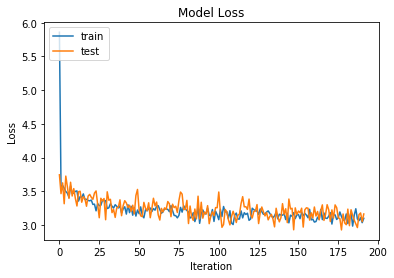

In [24]:
reg_machine.train(epochs=2)

In [ ]:
reg_machine.train(epochs=5)

Training for epoch 0
Training on batch 0 to 250 of 24000
Train on 2639 samples, validate on 655 samples
Epoch 1/1
2639/2639 [==============================] - 40s 15ms/step - loss: 3.1682 - val_loss: 3.0517
Training on batch 250 to 500 of 24000
Train on 2484 samples, validate on 658 samples
Epoch 1/1
2484/2484 [==============================] - 37s 15ms/step - loss: 2.9829 - val_loss: 3.1555
Training on batch 500 to 750 of 24000
Train on 2586 samples, validate on 583 samples
Epoch 1/1
2586/2586 [==============================] - 40s 16ms/step - loss: 3.1525 - val_loss: 3.3748
Training on batch 750 to 1000 of 24000
Train on 2613 samples, validate on 667 samples
Epoch 1/1
2613/2613 [==============================] - 42s 16ms/step - loss: 3.0892 - val_loss: 3.1288
Training on batch 1000 to 1250 of 24000
Train on 2532 samples, validate on 687 samples
Epoch 1/1
2532/2532 [==============================] - 40s 16ms/step - loss: 2.9887 - val_loss: 3.4371
Training on batch 1250 to 1500 of 2400

### Comments on Dropout & Regularisation

Interesting. 

While adding Dropout and regularisation appears to keep the training and test loss in sync, the model seems to struggle more to find a optima - the loss is higher and the model appears to find a pattern and stick to it (trapped in local minima?).